<a href="https://colab.research.google.com/github/johanhoffman/DD2363_VT21/blob/jacwah/Lab_4/jacwah_lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 4: Approximation**
**Jacob Wahlgren**

# **Abstract**

Piecewise linear approximation is implemented using $L^2$ projection. Accuracy and convergence is demonstrated by plotting approximations of various number of subintervals together with the exact function.

#**About the code**

The code was written by Jacob Wahlgren, based on a template by Johan Hoffman. For part of the lab I collaborated with Hilaire Bouaddi, though in the end we did not submit shared code.

In [54]:
"""This program is a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)
# Copyright (C) 2021 Jacob Wahlgren (jacobwah@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [58]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt

# **Introduction**

The piecewise polynomial approximation $P_Nf(x)$ is an approximation of an arbirtrary (integrable) function $f(x), x\in[a,b]$ using only polynomials. Piecewise means that $P_Nf$ is composed by different polynomials in different parts of its domain. To compute $P_Nf(x)$ we can use $L^2$ projection of $f(x)$ onto the a subspace of continuous piecewise polynomials. $L^2$ projection is defined in the Hilbert space $L^2([a,b])$ of scalar functions with the inner product

$\displaystyle (f,g) = \int_a^b f(x) g(x) dx.$

For this lab the focus is on polynomials of degree one only.
The subspace is defined by a nodal basis with nodes $(x_0,...,x_{m+1})$. The global basis vectors $\phi_i$ span the space.

$\displaystyle \phi_0(x) = \begin{cases}
  &\lambda_{1,0}(x) &x\in I_1 \\
  &0 &\text{otherwise}
\end{cases}$

$\displaystyle \phi_{m+1}(x) = \begin{cases}
  &\lambda_{m+1,1}(x) &x\in I_{m+1} \\
  &0 &\text{otherwise}
\end{cases}$

$\displaystyle \phi_i(x) = \begin{cases}
  &\lambda_{k,1}(x) &x\in I_k \\
  &\lambda_{k+1,0}(x) &x\in I_{k+1} \\
  &0 &\text{otherwise}
\end{cases}$

$\displaystyle \lambda_{k,0}(x) = \frac{x_k-x}{x_k-x_{k-1}} \quad \lambda_{k,1} = \frac{x-x_{k-1}}{x_k-x_{k-1}}$

A function $v(x)$ in the subspace can be expressed as

$\displaystyle v(x) = \sum_{i=0}^{m+1} \alpha_i \phi_i(x) = \sum_{j=0}^1 \beta_{k,j} \lambda_{k,j}(x)$

where $k$ is the interval of $x$ and $\alpha_k = \beta_{k,1} = \beta_{k+1,0}$.

Since only two basis vectors are non-zero in any interval computation and storage is efficient. The coordinates $\alpha$ can be computed using the assembly algorithm, and can then be used with the nodes to evaluate $P_Nf(x)$.

# **Method**

The following code is based on algorithms 9.1 and 9.2 in the lecture notes. However, some parts are differnent, since I could not get it to work when written exactly like in the lecture notes. For instance, in `assemble_system` the element `q` is indexed from 1, and the calls to `integrate_vector` and `integrate_matrix` have the indices `i` and `j` offset by `k`. (After looking at the indexing in my code a second time, I think it looks weird too, but I do not have time to fix it now.)

The integrals are computed using the `scipy.integrate.quad` function, which computes an approximation of the integral of arbitrary functions.

In [177]:
class Mesh:
  def __init__(self, nodes):
    self.nodes = nodes
    self.n = len(nodes)

  def find_subinterval(self, x):
    if x < self.nodes[0] or x > self.nodes[-1]:
      raise ValueError("x out of range")
    k = 1
    while x > self.nodes[k]:
      k += 1
    return k

  def get_no_local_shape_functions(self, k):
    if k == 1 or k == self.n-1:
      return 1
    else:
      return 2
  
  def h(self, i):
    return self.nodes[i] - self.nodes[i-1]

  def lagrange0(self, k, x):
    return (self.nodes[k] - x) / self.h(k)

  def lagrange1(self, k, x):
    return (x - self.nodes[k-1]) / self.h(k)

  def integrate_vector(self, f, k, i):
    if i == k:
      p = lambda x: self.lagrange1(k, x)
    elif i == k-1:
      p = lambda x: self.lagrange0(k, x)
    else:
      return 0

    return scipy.integrate.quad(lambda x: f(x)*p(x), self.nodes[k-1], self.nodes[k])[0]

  def integrate_matrix(self, k, i, j):
    if i == k:
      p = lambda x: self.lagrange1(k, x)
    elif i == k-1:
      p = lambda x: self.lagrange0(k, x)
    else:
      return 0
    if j == k:
      q = lambda x: self.lagrange1(k, x)
    elif j == k-1:
      q = lambda x: self.lagrange0(k, x)
    else:
      return 0

    return scipy.integrate.quad(lambda x: p(x)*q(x), self.nodes[k-1], self.nodes[k])[0]

  def assemble_system(self, f):
    A_glob = np.zeros((self.n, self.n))
    b_glob = np.zeros(self.n)

    for k in range(1, len(self.nodes)):
      q = self.get_no_local_shape_functions(k)
      A_loc = np.zeros((q+1, q+1))
      b_loc = np.zeros(q+1)

      for i in range(q+1):
        b_loc[i] = self.integrate_vector(f, k, k-i)
        for j in range(q+1):
          A_loc[i,j] = self.integrate_matrix(k, k-i, k-j)
      
      A_glob[k-1:k+q, k-1:k+q] += A_loc
      b_glob[k-1:k+q] += b_loc

    return A_glob, b_glob

  def alpha(self, f):
    A, b = self.assemble_system(f)
    return np.linalg.solve(A, b)

  def get_local_dofs(self, alpha, k):
    return np.array([alpha[k-1], alpha[k]])

  def eval_pw_linear(self, alpha, x):
    k = self.find_subinterval(x)
    beta = self.get_local_dofs(alpha, k)
    lambd = np.array([self.lagrange0(k, x), self.lagrange1(k, x)])
    return beta@lambd

# **Results**

The following code generates a random function $f(x)=c_1 \sin(x)+ c_2 \sin^2(x)$ and then computes an approximation using the previously defined $L^2$ projection. The approximation is computed for various numbers of equidistant and random nodes.  The graphs illustrate that as the number of nodes increase, the approximation approaches the exact function. The random nodes generally do worse than the equidistant nodes.

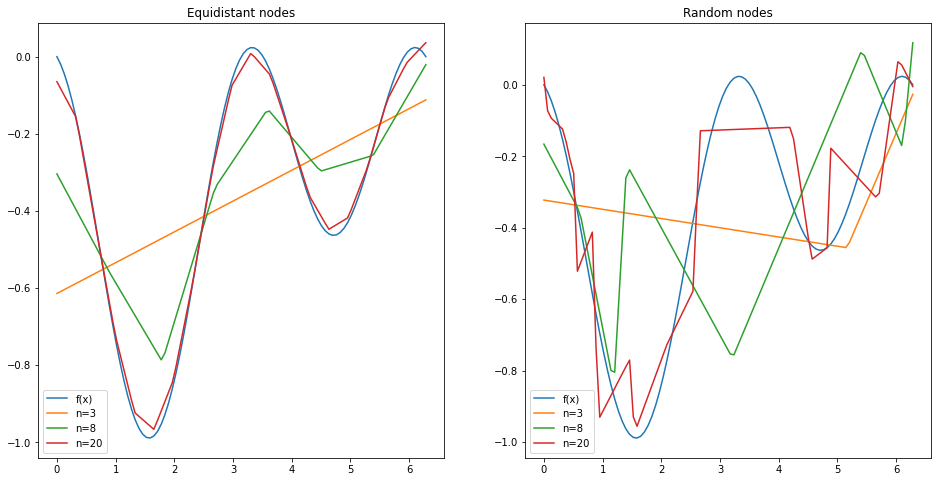

In [216]:
#np.random.seed(0)

c = 2*(np.random.rand(2)-1/2)
f = lambda x: c @ np.array([np.sin(x), np.sin(x)**2])

def equidistant_nodes(n):
  return np.linspace(0, 2*np.pi, n)

def random_nodes(n):
  internal = 2*np.pi*np.sort(np.random.rand(n-2))
  return np.concatenate((np.array([0]), internal, np.array([2*np.pi])))

xs = np.linspace(0, 2*np.pi, 100)

fig, (eax, rax) = plt.subplots(1, 2, figsize=(16, 8))

eax.plot(xs, f(xs), label="f(x)")
eax.set_title("Equidistant nodes")
rax.plot(xs, f(xs), label="f(x)")
rax.set_title("Random nodes")

def plot(ax, nodes):
  mesh = Mesh(nodes)
  alpha = mesh.alpha(f)
  approx = lambda x: mesh.eval_pw_linear(alpha, x)
  ax.plot(xs, list(map(approx, xs)), label=f"n={n}")

for n in (3, 8, 20):
  plot(eax, equidistant_nodes(n))
  plot(rax, random_nodes(n))

eax.legend()
rax.legend()

# **Discussion**

The algorithm was tricky to implement since it is quite complex, and also the descriptions in the lecture notes are somewhat confusing (e.g. inconsitent indexing). In previous assignments I have used the `unittest` package for the tests/results, but I was inspired by Hilaire to instead present the results as plots. It would have been much harder to debug without having the plots, so I will continue using this method when possible.

The accuracy seems quite high even when not using that many nodes, at least for lower frequency functions. But since the algorithm would be linear if implemented with sparse matrices, it seems that a large number of nodes would be possible if high accuracy is required. This method seems useful if the exact function is expensive to compute, since to evaluate the approximation is very cheap, especially if a grid is used.
